# mOWL: Python library for machine learning with ontologies

## Ontology creation:
To get started, you can install mOWL using pip:

In [ ]:
!pip install mowl-borg

mOWL interfaces the OWL API. For this, we need to interface with the Java Virtual Machine (JVM):

In [1]:
import mowl
mowl.init_jvm("10g")

In [2]:
import os
from java.util import HashSet
from mowl.owlapi import OWLAPIAdapter
from org.semanticweb.owlapi.model import IRI

## Let's create our first ontology

In [3]:
adapter = OWLAPIAdapter()
ontology = adapter.create_ontology("http://mowl/family")

## Concept names

In [4]:
male = adapter.create_class("http://Male")
female = adapter.create_class("http://Female")
parent = adapter.create_class("http://Parent")
person = adapter.create_class("http://Person")
mother = adapter.create_class("http://Mother")
father = adapter.create_class("http://Father")
sibling = adapter.create_class("http://Sibling")
brother = adapter.create_class("http://Brother")
sister = adapter.create_class("http://Sister")
son = adapter.create_class("http://Son")
daughter = adapter.create_class("http://Daughter")

## Role names

In [5]:
has_child = adapter.create_object_property("http://hasChild")
has_parent = adapter.create_object_property("http://hasParent")

## Individual names

In [6]:
John = adapter.create_individual("http://John")
Jane = adapter.create_individual("http://Jane")
Robert = adapter.create_individual("http://Robert")
Melissa = adapter.create_individual("http://Melissa")

## Axioms

Let's create some axioms of the form $A \sqsubseteq B$.

In [7]:
axioms = HashSet()
axioms.add(adapter.create_subclass_of(male, person))
axioms.add(adapter.create_subclass_of(female, person))
axioms.add(adapter.create_subclass_of(parent, person))
axioms.add(adapter.create_subclass_of(mother, female))
axioms.add(adapter.create_subclass_of(father, male))

True

Now, let's create some axioms of the form $A \sqcap B \sqsubseteq C$.

In [8]:
parent_and_male = adapter.create_object_intersection_of(parent, male)
axioms.add(adapter.create_subclass_of(parent_and_male, father))
parent_and_female = adapter.create_object_intersection_of(parent, female)
axioms.add(adapter.create_subclass_of(parent_and_female, mother))

True

Now some axioms of the form $A \sqcup B \equiv C$.

In [9]:
male_or_female = adapter.create_object_union_of(male, female)
axioms.add(adapter.create_equivalent_classes(male_or_female, person))

True

One axiom of the form $\neg A \equiv  B$.

In [10]:
not_male = adapter.create_complement_of(male)
axioms.add(adapter.create_equivalent_classes(not_male, female))

True

One axiom of the form $A \sqsubseteq \exists R.B$.

In [11]:
has_child_person = adapter.create_object_some_values_from(has_child, person)
axioms.add(adapter.create_subclass_of(parent, has_child_person))

True

And finally, some assertion axioms of the form $C(a)$ and $R(a,b)$.

In [12]:
axioms.add(adapter.create_class_assertion(father, John))
axioms.add(adapter.create_class_assertion(mother, Jane))
axioms.add(adapter.create_class_assertion(male, Robert))
axioms.add(adapter.create_class_assertion(female, Melissa))
axioms.add(adapter.create_object_property_assertion(has_child, John, Robert))
axioms.add(adapter.create_object_property_assertion(has_child, Jane, Robert))
axioms.add(adapter.create_object_property_assertion(has_child, John, Melissa))
axioms.add(adapter.create_object_property_assertion(has_child, Jane, Melissa))
adapter.owl_manager.addAxioms(ontology, axioms)

<java object 'org.semanticweb.owlapi.model.parameters.ChangeApplied'>

In [13]:
ont_file = os.path.abspath(f'family.owl')

In [14]:
adapter.owl_manager.saveOntology(ontology, IRI.create('file://'+ont_file))

In [15]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/mowl-tutorial/notebooks")

ModuleNotFoundError: No module named 'google.colab'

# Graph-based embeddings of ontologies

Ontologies are formed by a TBox, an ABox and an RBox. A Knowledge
Graph can be easily extracted from the ABox and the RBox. However, to
encode the graph representation of the TBox, which is composed by
(complex) concept descriptions, many approaches have been developed. In mOWL, we provide some
methods that perform ontology projection into graphs:

- **Taxonomy projection**: the projection of axioms of the form $A
\sqsubseteq B$ as edges $(A, subclassof, B)$.

- **Taxonomy + relations**: the projection of axioms of the form $A
\sqsubseteq B$ and $A \sqsubseteq \exists R.B$ as edges $(A,
subclassof, B)$ and $(A, R, B)$, respectively.

- **DL2Vec projection**

- **OWL2Vec projection**

In [16]:

import mowl
mowl.init_jvm("10g")

from mowl.projection import TaxonomyProjector, TaxonomyWithRelationsProjector, DL2VecProjector, OWL2VecStarProjector

In [17]:
#from mowl.datasets.builtin import FamilyDataset
from mowl.datasets import PathDataset
#dataset = FamilyDataset()
dataset = PathDataset("data/family.owl")
edges = TaxonomyProjector().project(dataset.ontology)

for edge in edges:
    src = edge.src.split("/")[-1]
    rel = edge.rel.split("/")[-1]
    dst = edge.dst.split("/")[-1]
    print(f"{src}\t{rel}\t{dst}")

INFO: Number of ontology classes: 6
Father	subclassof	Male
Female	subclassof	Person
Male	subclassof	Person
Mother	subclassof	Female
Parent	subclassof	Person


In [18]:
def nx_network(edges):
    import networkx as nx
    import matplotlib.pyplot as plt
    G = nx.DiGraph()
    for edge in edges:
        src = edge.src.split("/")[-1]
        dst = edge.dst.split("/")[-1]
        G.add_edge(src, dst)
    #nx draw with custom colors
    plt.figure(figsize=(5,5))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='cyan', alpha=0.9,
            labels={node:node for node in G.nodes()})
    #nx.draw(G, with_labels=True)
    plt.show()

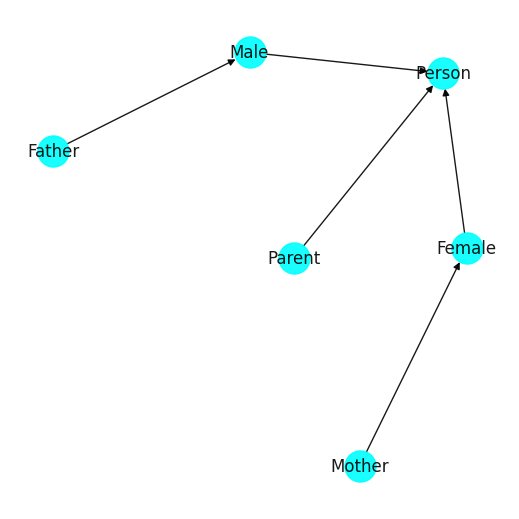

In [19]:
nx_network(edges)

In [20]:
dl2vec_proj = DL2VecProjector(bidirectional_taxonomy=True)
d2v_edges = dl2vec_proj.project(dataset.ontology, with_individuals=True)

for edge in d2v_edges:
    src = edge.src.split("/")[-1]
    rel = edge.rel.split("/")[-1]
    dst = edge.dst.split("/")[-1]
    print(f"{src}\t{rel}\t{dst}")

Jane	hasChild	Melissa
Parent	hasChild	Person
John	hasChild	Melissa
Female	subclassof	Person
Person	superclassof	Female
Father	subclassof	Male
Male	superclassof	Father
Jane	hasChild	Robert
Male	subclassof	Person
Person	superclassof	Male
Parent	subclassof	Person
Person	superclassof	Parent
Mother	subclassof	Female
Female	superclassof	Mother
John	hasChild	Robert


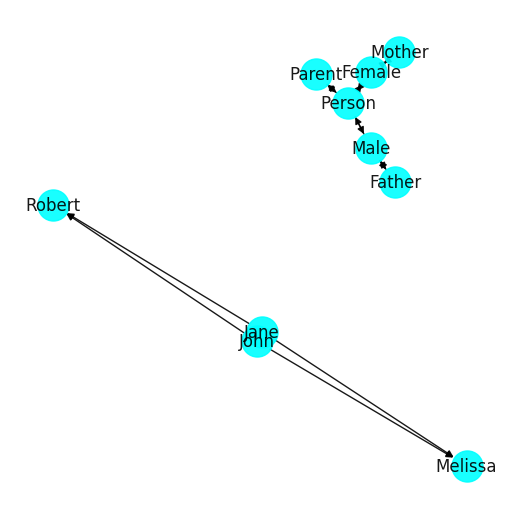

In [21]:
nx_network(d2v_edges)



In [22]:
owl2vec_proj = OWL2VecStarProjector(bidirectional_taxonomy=True)
o2v_edges = owl2vec_proj.project(dataset.ontology)

subRoles: Map()
inverseRoles: Map()


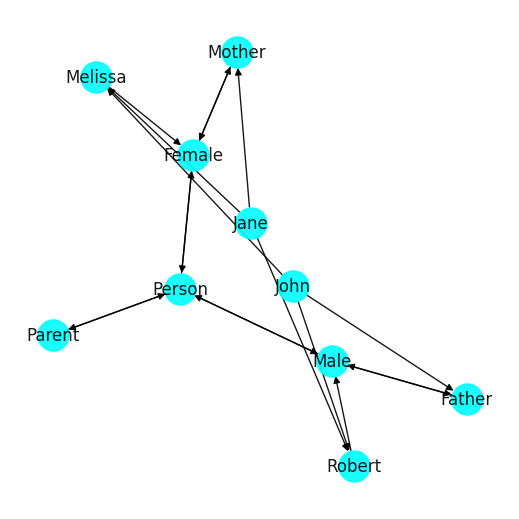

In [23]:
nx_network(o2v_edges)




# Syntactic embeddings of ontologies

Syntactic embeddings embedding uses the syntax of axioms to generate sentences out of them. mOWL provides methods to generate text sentences from the axioms and/or the annotations in the ontology. The syntax chosen to generate the sentences is [Manchester Syntax](https://www.w3.org/2007/OWL/draft/ED-owl2-manchester-syntax-20081128/).

In [24]:
import mowl
mowl.init_jvm("10g")

We import our `Family Ontology` and the method `extract_axiom_corpus`, which extracts the axioms from the ontology and generates sentences in *Manchester Syntax*.

In [25]:
from mowl.corpus import extract_axiom_corpus
from mowl.datasets import PathDataset
dataset = PathDataset("data/family.owl")
corpus = extract_axiom_corpus(dataset.ontology)
len(corpus)

INFO:root:Generating axioms corpus


30

Let's see the corpus generated:

In [26]:
for s in corpus[:10]:
    print(s)

http://Melissa Type http://Female
http://Jane Type http://Mother
http://Jane http://hasChild http://Melissa
http://Female and http://Parent SubClassOf http://Mother
http://Parent SubClassOf http://hasChild some http://Person
http://John http://hasChild http://Melissa
Individual: http://Robert
http://John Type http://Father
http://Female DisjointWith http://Male
Class: http://Person


Now it is possible to input this corpus in a model like Word2Vec, which will generate numerical representations for our vocabulary. We will use the `gensim` library to do this.

In [27]:
from gensim.models import Word2Vec

sentences = [s.split(" ") for s in corpus]
w2v = Word2Vec(sentences, epochs=200, vector_size = 50, min_count = 0)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 22 word types from a corpus of 88 raw words and 30 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 22 unique words (100.00% of original 22, drops 0)', 'datetime': '2023-02-07T18:18:10.773721', 'gensim': '4.3.0', 'python': '3.8.0 (default, Nov  6 2019, 21:49:08) \n[GCC 7.3.0]', 'platform': 'Linux-5.15.0-58-generic-x86_64-with-glibc2.10', 'event': 'prepare_vocab'}
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 88 word corpus (100.00% of original 88, drops 0)', 'datetime': '2023-02-07T18:18:10.774310', 'gensim': '4.3.0', 'python': '3.8.0 (default, Nov  6 2019, 21:49:08) \n[GCC 7.3.0]', 'platform': 'Linux-5.15.0-58-generic-x86_64-with-glibc2.10', 'event': 'prepare

INFO:gensim.models.word2vec:EPOCH 50: training on 88 raw words (18 effective words) took 0.0s, 21410 effective words/s
INFO:gensim.models.word2vec:EPOCH 51: training on 88 raw words (6 effective words) took 0.0s, 3964 effective words/s
INFO:gensim.models.word2vec:EPOCH 52: training on 88 raw words (14 effective words) took 0.0s, 17299 effective words/s
INFO:gensim.models.word2vec:EPOCH 53: training on 88 raw words (13 effective words) took 0.0s, 58601 effective words/s
INFO:gensim.models.word2vec:EPOCH 54: training on 88 raw words (14 effective words) took 0.0s, 53954 effective words/s
INFO:gensim.models.word2vec:EPOCH 55: training on 88 raw words (19 effective words) took 0.0s, 21914 effective words/s
INFO:gensim.models.word2vec:EPOCH 56: training on 88 raw words (15 effective words) took 0.0s, 17815 effective words/s
INFO:gensim.models.word2vec:EPOCH 57: training on 88 raw words (14 effective words) took 0.0s, 19811 effective words/s
INFO:gensim.models.word2vec:EPOCH 58: training on 

INFO:gensim.models.word2vec:EPOCH 119: training on 88 raw words (13 effective words) took 0.0s, 18983 effective words/s
INFO:gensim.models.word2vec:EPOCH 120: training on 88 raw words (10 effective words) took 0.0s, 8334 effective words/s
INFO:gensim.models.word2vec:EPOCH 121: training on 88 raw words (17 effective words) took 0.0s, 24022 effective words/s
INFO:gensim.models.word2vec:EPOCH 122: training on 88 raw words (14 effective words) took 0.0s, 21563 effective words/s
INFO:gensim.models.word2vec:EPOCH 123: training on 88 raw words (11 effective words) took 0.0s, 6107 effective words/s
INFO:gensim.models.word2vec:EPOCH 124: training on 88 raw words (13 effective words) took 0.0s, 14179 effective words/s
INFO:gensim.models.word2vec:EPOCH 125: training on 88 raw words (14 effective words) took 0.0s, 13841 effective words/s
INFO:gensim.models.word2vec:EPOCH 126: training on 88 raw words (19 effective words) took 0.0s, 16231 effective words/s
INFO:gensim.models.word2vec:EPOCH 127: tra

INFO:gensim.models.word2vec:EPOCH 188: training on 88 raw words (16 effective words) took 0.0s, 18813 effective words/s
INFO:gensim.models.word2vec:EPOCH 189: training on 88 raw words (16 effective words) took 0.0s, 15114 effective words/s
INFO:gensim.models.word2vec:EPOCH 190: training on 88 raw words (21 effective words) took 0.0s, 31229 effective words/s
INFO:gensim.models.word2vec:EPOCH 191: training on 88 raw words (18 effective words) took 0.0s, 33203 effective words/s
INFO:gensim.models.word2vec:EPOCH 192: training on 88 raw words (11 effective words) took 0.0s, 15004 effective words/s
INFO:gensim.models.word2vec:EPOCH 193: training on 88 raw words (18 effective words) took 0.0s, 20377 effective words/s
INFO:gensim.models.word2vec:EPOCH 194: training on 88 raw words (14 effective words) took 0.0s, 17422 effective words/s
INFO:gensim.models.word2vec:EPOCH 195: training on 88 raw words (13 effective words) took 0.0s, 14499 effective words/s
INFO:gensim.models.word2vec:EPOCH 196: t

Finally, we can provide a visual representation of the entities. We will use a modified version of TSNE, which is implemented in mOWL:

In [28]:
from scripts.tsne import TSNE

vectors = w2v.wv
vocab_dict = vectors.key_to_index
name_to_label = {c: c.split("/")[-1] for c in vocab_dict if str(c).startswith("http://")}
name_to_emb = {c: vectors[[c]][0] for c in name_to_label}

tsne = TSNE(name_to_emb, name_to_label)
tsne.generate_points(500, workers=4)

INFO:root:Found 11 embedding vectors. Processing only 11.


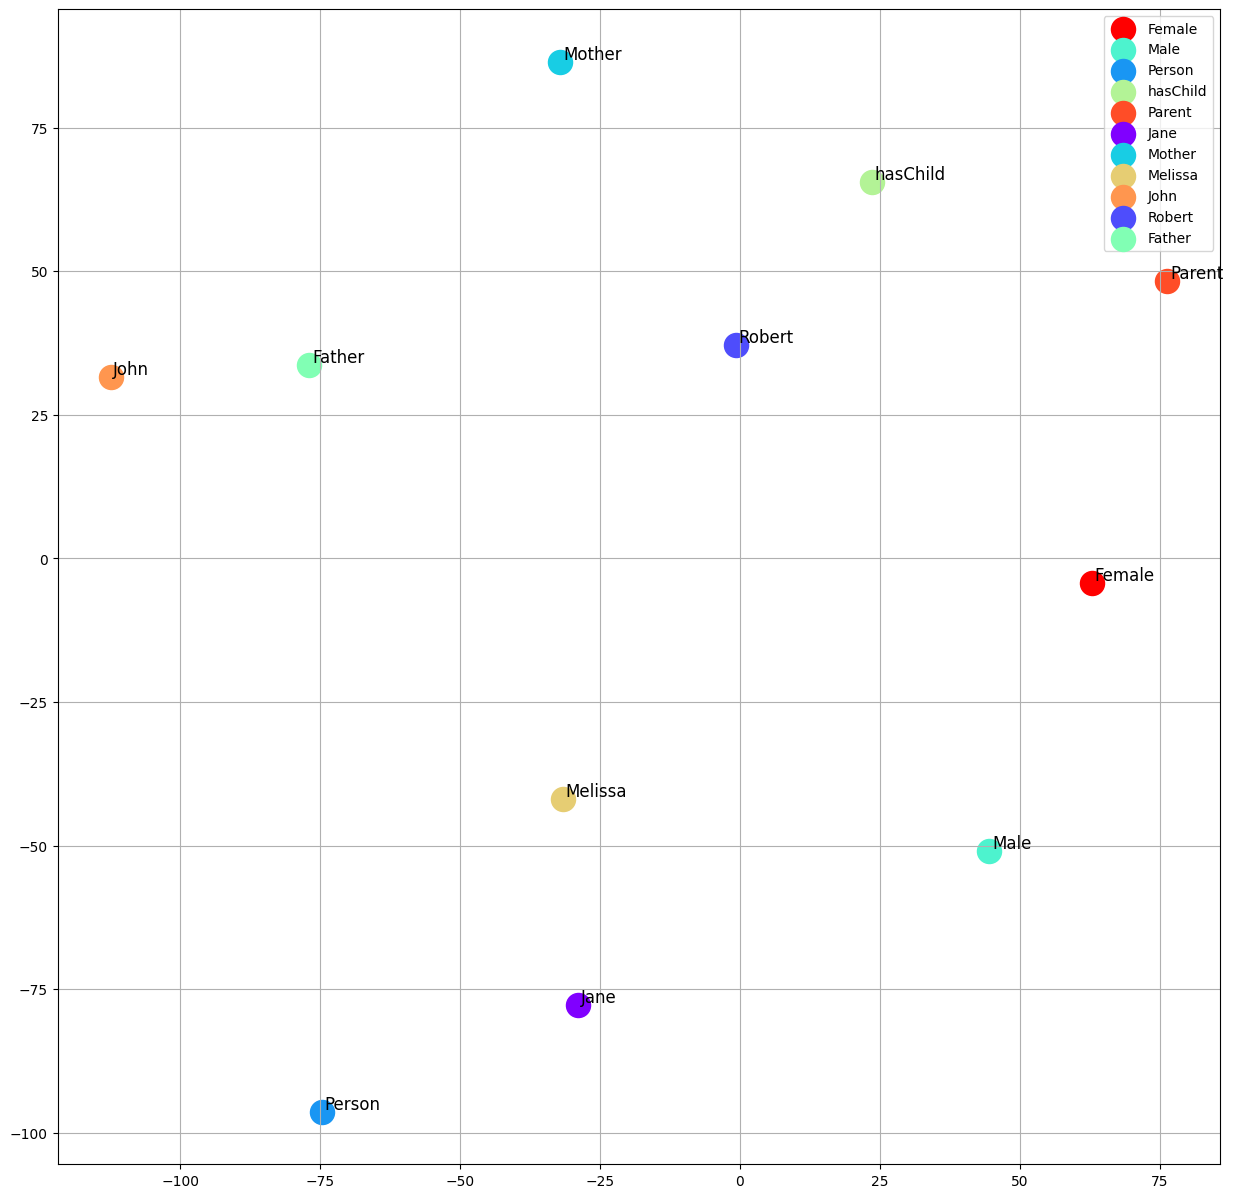

In [29]:
tsne.show(thickness=300)

## Data augmentation via reasoning

We can generate more axioms by performing reasoning over the current ontology. mOWL provides access to ELK and Hermit reasoners. Those reasoners can be accessed using the OWLAPI directly or using the `MOWLReasoner` wrapper class that provides some shortcuts to reasoner methods.

In [30]:
from mowl.reasoning.base import MOWLReasoner
from org.semanticweb.HermiT import Reasoner

reasoner = Reasoner.ReasonerFactory().createReasoner(dataset.ontology)
reasoner.precomputeInferences()

mowl_reasoner = MOWLReasoner(reasoner)
classes_to_infer_over = list(dataset.ontology.getClassesInSignature())

subclass_axioms = mowl_reasoner.infer_subclass_axioms(classes_to_infer_over)
equivalence_axioms = mowl_reasoner.infer_equivalent_class_axioms(classes_to_infer_over)
disjointness_axioms = mowl_reasoner.infer_disjoint_class_axioms(classes_to_infer_over)

INFO:root:Number of inferred axioms: 12.
INFO:root:Number of inferred axioms: 6.
INFO:root:Number of inferred axioms: 6.


Once the axioms were generated, it is time to add them to the ontology:

In [31]:
from mowl.owlapi import OWLAPIAdapter

manager = OWLAPIAdapter().owl_manager

for ax in subclass_axioms:
    manager.addAxiom(dataset.ontology, ax)
for ax in equivalence_axioms:
    manager.addAxiom(dataset.ontology, ax)
for ax in disjointness_axioms:
    manager.addAxiom(dataset.ontology, ax)

Then we can do the embedding process with the updated ontology:

In [32]:
corpus = extract_axiom_corpus(dataset.ontology)
print(f"The inferred ontology contains {len(corpus)} axioms")

INFO:root:Generating axioms corpus


The inferred ontology contains 49 axioms


In [33]:
sentences = [str(s).split(" ") for s in corpus]
sentences = [[w.replace(",", "") for w in s] for s in sentences]
w2v = Word2Vec(sentences, epochs=200, vector_size = 50, min_count = 0)

vectors = w2v.wv
vocab_dict = vectors.key_to_index
name_to_label = {c: c.split("/")[-1] for c in vocab_dict if str(c).startswith("http://")}
name_to_emb = {c: vectors[[c]][0] for c in name_to_label}

tsne = TSNE(name_to_emb, name_to_label)
tsne.generate_points(500, workers=4)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 27 word types from a corpus of 157 raw words and 49 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 27 unique words (100.00% of original 27, drops 0)', 'datetime': '2023-02-07T18:18:14.750588', 'gensim': '4.3.0', 'python': '3.8.0 (default, Nov  6 2019, 21:49:08) \n[GCC 7.3.0]', 'platform': 'Linux-5.15.0-58-generic-x86_64-with-glibc2.10', 'event': 'prepare_vocab'}
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 157 word corpus (100.00% of original 157, drops 0)', 'datetime': '2023-02-07T18:18:14.750888', 'gensim': '4.3.0', 'python': '3.8.0 (default, Nov  6 2019, 21:49:08) \n[GCC 7.3.0]', 'platform': 'Linux-5.15.0-58-generic-x86_64-with-glibc2.10', 'event': 'prep

INFO:gensim.models.word2vec:EPOCH 49: training on 157 raw words (32 effective words) took 0.0s, 94568 effective words/s
INFO:gensim.models.word2vec:EPOCH 50: training on 157 raw words (27 effective words) took 0.0s, 220065 effective words/s
INFO:gensim.models.word2vec:EPOCH 51: training on 157 raw words (35 effective words) took 0.0s, 168667 effective words/s
INFO:gensim.models.word2vec:EPOCH 52: training on 157 raw words (21 effective words) took 0.0s, 56427 effective words/s
INFO:gensim.models.word2vec:EPOCH 53: training on 157 raw words (23 effective words) took 0.0s, 67655 effective words/s
INFO:gensim.models.word2vec:EPOCH 54: training on 157 raw words (25 effective words) took 0.0s, 120391 effective words/s
INFO:gensim.models.word2vec:EPOCH 55: training on 157 raw words (26 effective words) took 0.0s, 132770 effective words/s
INFO:gensim.models.word2vec:EPOCH 56: training on 157 raw words (27 effective words) took 0.0s, 148071 effective words/s
INFO:gensim.models.word2vec:EPOCH 5

INFO:gensim.models.word2vec:EPOCH 117: training on 157 raw words (30 effective words) took 0.0s, 113636 effective words/s
INFO:gensim.models.word2vec:EPOCH 118: training on 157 raw words (33 effective words) took 0.0s, 135733 effective words/s
INFO:gensim.models.word2vec:EPOCH 119: training on 157 raw words (26 effective words) took 0.0s, 74972 effective words/s
INFO:gensim.models.word2vec:EPOCH 120: training on 157 raw words (26 effective words) took 0.0s, 52816 effective words/s
INFO:gensim.models.word2vec:EPOCH 121: training on 157 raw words (27 effective words) took 0.0s, 71192 effective words/s
INFO:gensim.models.word2vec:EPOCH 122: training on 157 raw words (27 effective words) took 0.0s, 109744 effective words/s
INFO:gensim.models.word2vec:EPOCH 123: training on 157 raw words (32 effective words) took 0.0s, 224321 effective words/s
INFO:gensim.models.word2vec:EPOCH 124: training on 157 raw words (28 effective words) took 0.0s, 183758 effective words/s
INFO:gensim.models.word2vec

INFO:gensim.models.word2vec:EPOCH 185: training on 157 raw words (27 effective words) took 0.0s, 112933 effective words/s
INFO:gensim.models.word2vec:EPOCH 186: training on 157 raw words (25 effective words) took 0.0s, 75482 effective words/s
INFO:gensim.models.word2vec:EPOCH 187: training on 157 raw words (26 effective words) took 0.0s, 73689 effective words/s
INFO:gensim.models.word2vec:EPOCH 188: training on 157 raw words (27 effective words) took 0.0s, 114571 effective words/s
INFO:gensim.models.word2vec:EPOCH 189: training on 157 raw words (25 effective words) took 0.0s, 57072 effective words/s
INFO:gensim.models.word2vec:EPOCH 190: training on 157 raw words (25 effective words) took 0.0s, 119242 effective words/s
INFO:gensim.models.word2vec:EPOCH 191: training on 157 raw words (29 effective words) took 0.0s, 123252 effective words/s
INFO:gensim.models.word2vec:EPOCH 192: training on 157 raw words (33 effective words) took 0.0s, 140025 effective words/s
INFO:gensim.models.word2vec

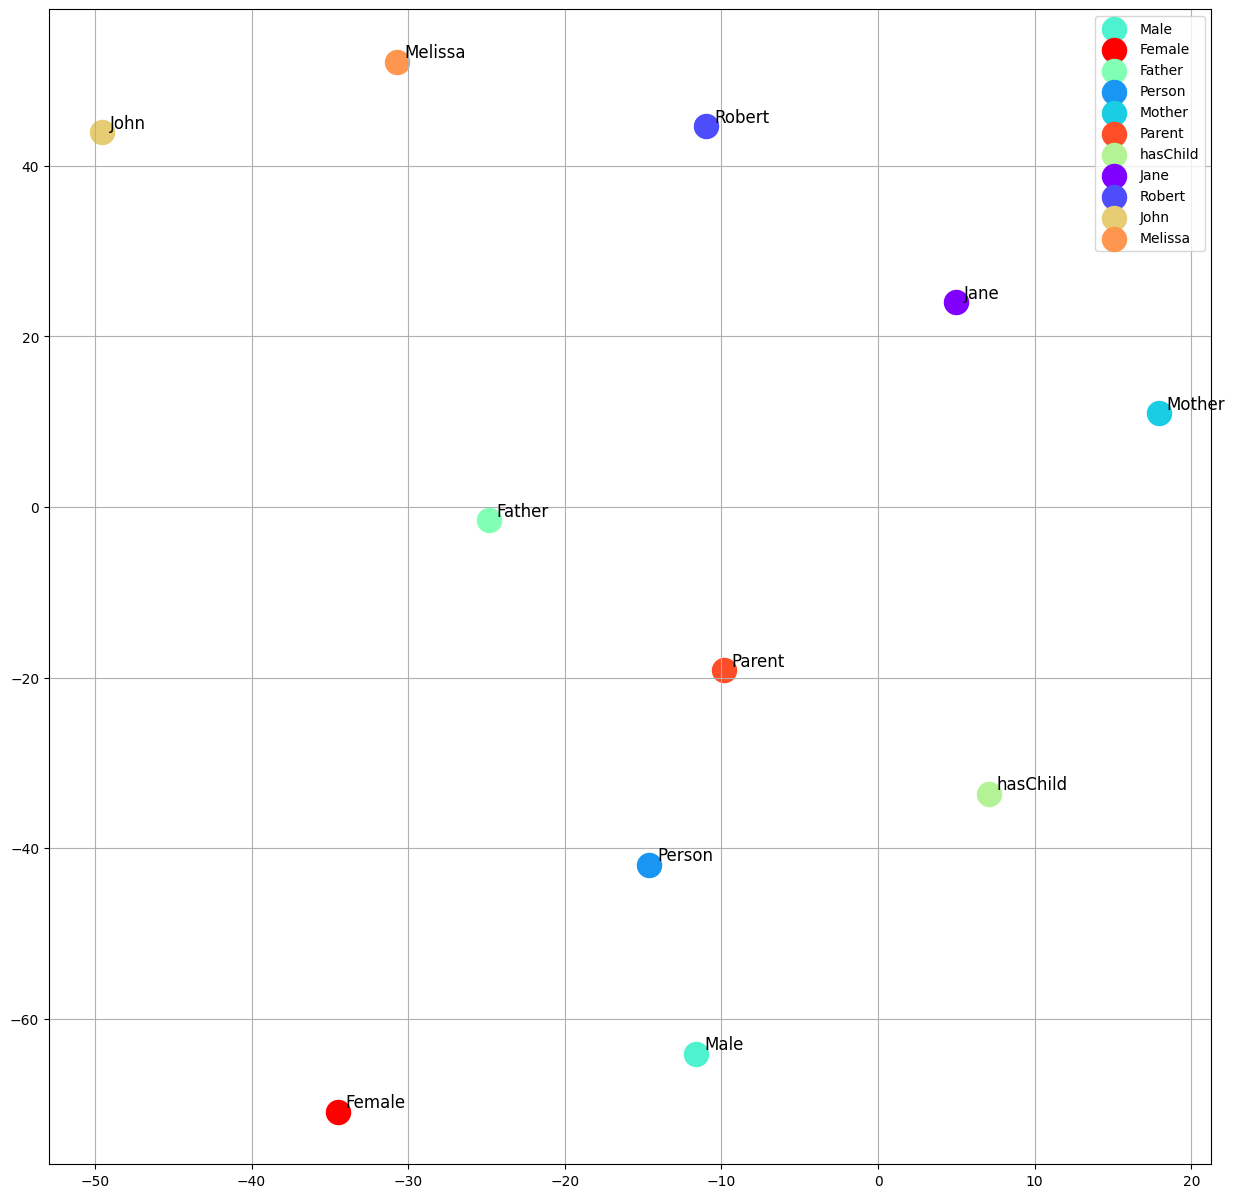

In [34]:
tsne.show(thickness=300)

**mOWL Input dataset:** ontology in OWL format

**Methods input:** takes vectors of genes and diseases 

**Output:** predict gene-disease association using cosine similarity


In [ ]:
#Install the tool using: 
! pip install gensim==4.0.0
! pip install mowl-borg 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
#cd /content/drive/MyDrive/mowl-tutorial/
import os
os.chdir("/content/drive/MyDrive/mowl-tutorial/")

In [ ]:
# built-in imports
import sys
import mowl
mowl.init_jvm("4g")
import torch as th
import logging
import numpy as np
import pickle as pkl
from mowl.visualization.base import TSNE
import matplotlib.pyplot as plt
from mowl.projection.edge import Edge
from mowl.datasets.builtin import GDADataset, GDAHumanDataset, GDAMouseDataset
from pykeen.models import TransE,ConvE,DistMult,TransR,TransD
from mowl.projection.dl2vec.model import DL2VecProjector 
from mowl.kge import KGEModel
from mowl.evaluation.rank_based import EmbeddingsRankBasedEvaluator
from mowl.evaluation.base import TranslationalScore, CosineSimilarity
from mowl.projection.factory import projector_factory, PARSING_METHODS
from mowl.walking import DeepWalk
from gensim.models.word2vec import LineSentence
import gensim
from gensim.models import Word2Vec
from mowl.evaluation.rank_based import EmbeddingsRankBasedEvaluator
from mowl.evaluation.base import CosineSimilarity
from mowl.projection import TaxonomyWithRelationsProjector
from mowl.projection.edge import Edge

import warnings  
warnings.filterwarnings(action='ignore',category=UserWarning,module='gensim')  
warnings.filterwarnings(action='ignore',category=FutureWarning,module='gensim') 

# Dataset 

Build your own dataset

In [ ]:
from mowl.ontology.extend import insert_annotations
 
diseases_annotations = ("diseases_annot.tsv", "http://has_annotation", True) 
genes_annotations = ("genes_annot.tsv", "http://has_annotation", True) 
gene_disease_associations = ("gene_disease_associations.tsv","http://is_associated_with/", True) 

annotations = [diseases_annotations , genes_annotations, gene_disease_associations] # There could be more than 1 annotations file. 

insert_annotations("upheno.owl", annotations, out_file = "upheno_with_annotations.owl" )

Use the Built-in Dataset

In [ ]:
dataset = GDAMouseDataset()

The dataset will be downloaded to a folder name `gda_mouse` with the training, validation and testing ontology dataset

In [ ]:
! ls gda_mouse/

# Graph-based embeddings

 ### Example for two methods: DL2vec and Owl2vec* methods

<font color='blue'><font size="4">1) DL2vec Prediction Method </font></font>


1. **Projecting the ontology** 
- Project the ontology using the DL2Vec Projector class, with the specific rules used to project the ontology. 
- The outcome of the projection algorithm is an edgelist.



In [ ]:
from mowl.projection.dl2vec.model import DL2VecProjector 
projector = DL2VecProjector(True)
train_edges = projector.project(dataset.ontology)
test_edges = projector.project(dataset.testing)

2. **Generating random walks**
- The random walks are generated using the DeepWalk.


In [ ]:
walker = DeepWalk(10, # number of walks per node
                  10, # walk length
                  0.1, # restart probability
                  workers=4, outfile = 'walk',seed=40) # number of threads

walks = walker.walk(train_edges)
walks_file = walker.outfile
sentences = LineSentence(walks_file)

3. **Training the Word2Vec model**
- To train the Word2Vec model, we rely on the Gensim library

In [ ]:
model = Word2Vec(sentences, vector_size=100, epochs = 15, window=5, min_count=1, workers=10)

4. **Evaluating the embeddings** 
- We are going to evaluate the plausibility of an association gene-disease with a gene against all possible diseases and check the rank of the true disease association using CosineSimilarity.


In [ ]:
genes, diseases = dataset.evaluation_classes
projector = TaxonomyWithRelationsProjector(taxonomy=False,
                                           relations=["http://is_associated_with"])

vectors = model.wv
evaluator = EmbeddingsRankBasedEvaluator(
    vectors,
    test_edges,
    CosineSimilarity,
    training_set=train_edges,
    head_entities = genes.as_str,
    tail_entities = diseases.as_str,
    device = 'cpu')


evaluator.evaluate(show=True)

In [ ]:
human_disease=[]
mouse_genes=[]
for classes in vectors.index_to_key:
    if 'OMIM' in classes:
        human_disease.append(classes)
    if classes[7:].isnumeric():
        mouse_genes.append(classes)

print(f'Number of the disease is {len(human_disease)}, and number of genes is {len(mouse_genes)}')

In [ ]:
human_disease[:10]

In [ ]:
mouse_genes[:10]

In [ ]:
human_disease_vectors=[]
for k in human_disease:
    human_disease_vectors.append(vectors[k]) 
    
mouse_genes_vectors=[]
for k in mouse_genes:
    mouse_genes_vectors.append(vectors[k])

from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(np.array(human_disease_vectors),np.array(mouse_genes_vectors))

print(f"The dimentions of this matrix is {similarity.shape}")

## Evaluating the predictions to find the most similar genes:

In [ ]:
def find_similar_genes(disease_id, top_k, disease_genes_similarity_matrix, disease_keys, gene_keys):
    disease_index = disease_keys.index(disease_id)
    prediction_list = np.flip(np.argsort(disease_genes_similarity_matrix[disease_index]))
    top_genes = [gene_keys[prediction_list[x]] for x in range(top_k)]
    
    return top_genes

#associations from the file MGI_DO.rpt

      
#DOID:0080449	developmental and epileptic encephalopathy 16	OMIM:615338	mouse, laboratory	10090	Tbc1d24	224617	MGI:2443456
disease_id = 'http://OMIM_615338' 
top_k = find_similar_genes(disease_id, 5 ,similarity, human_disease, mouse_genes )
print(f'The most similar gene to disease {disease_id.split("/")[2]} are: {top_k}')

      
#DOID:0080436	developmental and epileptic encephalopathy 4	OMIM:612164	human	9606	STXBP1	6812	
#DOID:0060309	syndromic X-linked intellectual disability		human	9606	HNRNPH2	3188	
#HNRNPH2	3188	Hnrnph2	MGI:1201779	MP:0001186, MP:0005386, MP:0010771	      
#disease_id = 'http://OMIM_612164' 
#top_k = find_similar_genes(disease_id, 5 ,similarity, human_disease, mouse_genes )
#print(f'The most similar gene to disease {disease_id.split("/")[2]} are: {top_k}')


#OMIM_181500 : schizophrenia : DOID:5419	OMIM:181500	mouse, laboratory	10090	Magi2	50791	MGI:1354953
#disease_id = 'http://OMIM_181500' 
#top_k = find_similar_genes(disease_id, 5 ,similarity, human_disease, mouse_genes )
#print(f'The most similar gene to disease {disease_id.split("/")[2]} are: {top_k}')
      

#OMIM_615643 : neurodegeneration with brain iron accumulation 6
#DOID:0110740	OMIM:615643	mouse, laboratory	10090	Coasy	71743	MGI:1918993
#disease_id = 'http://OMIM_615643' 
#top_k = find_similar_genes(disease_id, 5 ,similarity, human_disease, mouse_genes )
#print(f'The most similar gene to disease {disease_id.split("/")[2]} are: {top_k}')

In [ ]:
def find_similar_genes(disease_id, top_k, disease_genes_similarity_matrix, disease_keys, gene_keys):
    disease_index = disease_keys.index(disease_id)
    prediction_list = np.flip(np.argsort(disease_genes_similarity_matrix[disease_index]))
    top_genes = [gene_keys[prediction_list[x]] for x in range(top_k)]
    
    return top_genes

disease_id = 'http://OMIM_615643' 
top_k = find_similar_genes(disease_id, 5 ,similarity, human_disease, mouse_genes )
print(f'The most similar gene to disease {disease_id.split("/")[2]} are: {top_k}')

-------------------------------------

# **Task 1 :**

<div class="alert alert-block alert-success" , color ='grreen'> 

<font size="4"> 
    Predict the <font color='SteelBlue'>top 10 similar genes</font> to 
    diabetes mellitus disease OMIM ID: <font color='Tomato'>http://OMIM_608036</font>
    using <font color='red'>OWL2vec*</font> prediction method

</font>

</div>


<div class="alert alert-block alert-info">
<b>Tip:</b> Follow the <b>TODO</b> interactions to modify the script, and the rest should be the same you just need to run the cell to execute the code.
</div>


----

<font color='blue'><font size="4">2) OWL2vec* Prediction Method </font></font> 


1. **Projecting the ontology** 
- Project the ontology using the OWL2Vec* Projector class, with the specific rules used to project the ontology. 
- The outcome of the projection algorithm is an edgelist.


In [ ]:
from mowl.projection import #TODO: import the appropriate function (refer to https://mowl.readthedocs.io/en/latest/api/projection/index.html)
dataset = GDAMouseDataset()
projector = OWL2VecStarProjector(True)
train_edges = projector.project(dataset.ontology)
test_edges = projector.project(dataset.testing)

2. **Generating random walks**
- The random walks are generated using the DeepWalk.


In [ ]:
walker = DeepWalk( ,#TODO: add the number of walks per node
                   ,#TODO: add the walk length
                  workers=4, # number of threads
                  outfile = , #TODO: add the name of the output file for the walks
                  seed=40) #fix the random seed 

walks = walker.walk(train_edges)
walks_file = walker.outfile
sentences = LineSentence(walks_file)

3. **Training the Word2Vec model**
- To train the Word2Vec model, we rely on the Gensim library

In [ ]:
model = Word2Vec(sentences, 
                 vector_size= , #TODO: add the size of the vector
                 epochs = ,     #TODO: update the number of training epochs
                 window=5, min_count=1, workers=10)

4. **Evaluating the embeddings** 
- We are going to evaluate the plausibility of an association gene-disease with a gene against all possible diseases and check the rank of the true disease association using CosineSimilarity.


In [ ]:
genes, diseases = dataset.evaluation_classes
projector = TaxonomyWithRelationsProjector(taxonomy=False,
                                           relations=["http://is_associated_with"])

vectors = model.wv
evaluator = EmbeddingsRankBasedEvaluator(
    vectors,
    test_edges,
    CosineSimilarity,
    training_set=train_edges,
    head_entities = genes.as_str,
    tail_entities = diseases.as_str,
    device = 'cuda')

evaluator.evaluate(show=True)

In [ ]:
human_disease=[]
mouse_genes=[]
for classes in vectors.index_to_key:
    if 'OMIM' in classes:
        human_disease.append(classes)
    if classes[7:].isnumeric():
        mouse_genes.append(classes)

print(f'Number of the disease is {len(human_disease)}, and number of genes is {len(mouse_genes)}')

In [ ]:
human_disease_vectors=[]
for k in human_disease:
    human_disease_vectors.append(vectors[k]) 
    
mouse_genes_vectors=[]
for k in mouse_genes:
    mouse_genes_vectors.append(vectors[k])

from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(np.array(human_disease_vectors),np.array(mouse_genes_vectors))

print("the dimentions of this matrix is ", similarity.shape)

## Evaluating the predictions to find the most similar genes:

In [ ]:
def find_similar_genes(disease_id, top_k, disease_genes_similarity_matrix, disease_keys, gene_keys):
    disease_index = disease_keys.index(disease_id)
    prediction_list = np.flip(np.argsort(disease_genes_similarity_matrix[disease_index]))
    top_genes = [gene_keys[prediction_list[x]] for x in range(top_k)]
    
    return top_genes

  

disease_id = #TODO: write the disease OMIM ID

number_of_genes =  #TODO: number of genes to be ranked

top_k = find_similar_genes( , #TODO: disease OMIM ID
                            , #TODO: number of genes 
                           similarity, 
                           human_disease, 
                           mouse_genes)

print(f'The top {number_of_genes} most similar gene to disease {disease_id.split("/")[2]} are:')

for idx, genes in enumerate(top_k):
    print(f" Gene in Rank {idx+1} is : {top_k[idx]}")

----------------------------------------

# Syntactic embeddings

In [ ]:
from mowl.corpus import extract_and_save_axiom_corpus
from mowl.owlapi import OWLAPIAdapter
from mowl.reasoning import MOWLReasoner
from org.semanticweb.elk.owlapi import ElkReasonerFactory
from java.util import HashSet
from gensim.models.word2vec import LineSentence
from gensim.models import Word2Vec
import os

<font color='blue'><font size="4">1) Onto2Vec Prediction Method </font></font> 


This example corresponds to the paper **Onto2Vec: joint vector-based representation of biological entities and their ontology-based annotations**.

This method is an approach to learn numerical representations (embeddings) of (biomedical) ontologies by representing ontology axioms as text sequences and applying an unsupervised learning algorithm such as Word2Vec. Onto2Vec uses an ontology reasoner to infer new axioms as a preprocessing step. The algorithm is tested on the protein-protein interaction task.

For this algorithm, we need three components:

1. The reasoner

2. The corpus generator

3. The Word2Vec model

 
**1) Inferring new axioms**

- Onto2Vec uses an ontology reasoner to infer new axioms as a preprocessing step. In the original paper, the authors used the HermiT reasoner. For this example, we use the ELK reasoner.


In [ ]:
reasoner_factory = ElkReasonerFactory()
reasoner = reasoner_factory.createReasoner(dataset.ontology)
mowl_reasoner = MOWLReasoner(reasoner)

In [ ]:
# We wrap the reasoner into the :class:`MOWLReasoner <mowl.reasoning.base.MOWLReasoner>` class \
# in order to use some shortcuts the mOWL
# provides such as:
#
# - inferring subclass axioms
# - inferring equivalent class axioms
# - inferring disjoint axioms (not applicable for this example since we use ELK reasoner)

classes = dataset.ontology.getClassesInSignature()
subclass_axioms = mowl_reasoner.infer_subclass_axioms(classes)
equivalent_class_axioms = mowl_reasoner.infer_equivalent_class_axioms(classes)

In [ ]:
# We can now add the inferred axioms to the ontology.

adapter = OWLAPIAdapter()
manager = adapter.owl_manager

axioms = HashSet()
axioms.addAll(subclass_axioms)
axioms.addAll(equivalent_class_axioms)

manager.addAxioms(dataset.ontology, axioms)

**2- The corpus generator**

In [ ]:
extract_and_save_axiom_corpus(dataset.ontology, "onto2vec_corpus.txt")

**3- Generating the corpus and training the model**
- Now that we have an extended ontology, we can generate the corpus out of it. After that, we can train the Word2Vec model.


In [ ]:
sentences = LineSentence("onto2vec_corpus.txt")
model_onto = Word2Vec(sentences, vector_size=5, epochs=10, window=2, min_count=1, workers=4)

In [ ]:
# Cleaning up memory
# os.remove("onto2vec_corpus.txt")

## Evaluating the embeddings
- We are going to evaluate the plausibility of an association gene-disease with a gene against all possible diseases and check the rank of the true disease association using CosineSimilarity.


In [ ]:
genes, diseases = dataset.evaluation_classes
projector = TaxonomyWithRelationsProjector(taxonomy=False,
                                           relations=["http://is_associated_with"])

vectors = model_onto.wv
evaluator = EmbeddingsRankBasedEvaluator(
    vectors,
    test_edges,
    CosineSimilarity,
    training_set=train_edges,
    head_entities = genes.as_str,
    tail_entities = diseases.as_str,
    device = 'cpu')

evaluator.evaluate(show=True)

In [ ]:
human_disease=[]
mouse_genes=[]
for classes in vectors.index_to_key:
    if 'OMIM' in classes:
        human_disease.append(classes)
    if classes[7:].isnumeric():
        mouse_genes.append(classes)

human_disease_vectors=[]
for k in human_disease:
    human_disease_vectors.append(vectors[k]) 
    
mouse_genes_vectors=[]
for k in mouse_genes:
    mouse_genes_vectors.append(vectors[k])

similarity = cosine_similarity(np.array(human_disease_vectors),np.array(mouse_genes_vectors))

disease_id = 'http://OMIM_612164' 
top_k = find_similar_genes(disease_id, 10 ,similarity, human_disease, mouse_genes )
print(f'The most similar gene to disease {disease_id.split("/")[2]} are: {top_k}')

----

# **Task 2 :**

<div class="alert alert-block alert-success"> 

<font size="4"> 
    Predict the <font color='SteelBlue'>top 5 similar genes</font> to 
    diabetes mellitus disease OMIM ID: <font color='Tomato'>http://OMIM_608036</font>
    using <font color='red'>OPA2Vec*</font> prediction method

</font>

</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> Follow the <b>TODO</b> interactions to modify the script, and the rest should be the same you just need to run the cell to execute the code.
</div>


--- 

<font color='blue'><font size="4">2) OPA2Vec Prediction Method </font></font> 


This example corresponds to the paper **OPA2Vec: combining formal and informal content of biomedical ontologies to improve similarity-based prediction**.

This method is an extension of **Onto2Vec** that apart from formal knowldege (i.e. axioms) it also uses informal knowledge such as entity metadata (i.e. synonyms, definitions, etc.)

For this algorithm, we need four components:

1.  The reasoner

2. The corpus generator

<font color='red'>3. The annotations generator</font> 

4. The Word2Vec model

In [ ]:
from mowl.corpus import extract_and_save_axiom_corpus
from mowl.owlapi import OWLAPIAdapter
from mowl.reasoning import MOWLReasoner
from org.semanticweb.elk.owlapi import ElkReasonerFactory
from java.util import HashSet
from gensim.models.word2vec import LineSentence
from gensim.models import Word2Vec
import os
from sklearn.metrics.pairwise import cosine_similarity

from mowl.corpus import extract_and_save_axiom_corpus, extract_and_save_annotation_corpus
# OPA2Vec use annotation so we need to import extract_and_save_annotation_corpus


**1) Inferring new axioms**

- OPA2Vec uses an ontology reasoner to infer new axioms as a preprocessing step. In the original paper, the authors used the HermiT reasoner. For this example, we use the ELK reasoner.



In [ ]:
reasoner_factory = ElkReasonerFactory()
reasoner = reasoner_factory.createReasoner(dataset.ontology)
mowl_reasoner = MOWLReasoner(reasoner)

We wrap the reasoner into the **MOWLReasoner** class in order to use some shortcuts the mOWL provides such as:

- inferring subclass axioms

- inferring equivalent class axioms

- inferring disjoint axioms (not applicable for this example since we use ELK reasoner)


In [ ]:
classes = dataset.ontology.getClassesInSignature()
subclass_axioms = mowl_reasoner.infer_subclass_axioms(classes)
equivalent_class_axioms = mowl_reasoner.infer_equivalent_class_axioms(classes)

We can now add the inferred axioms to the ontology:

**2- The corpus generator**

In [ ]:
adapter = OWLAPIAdapter()
manager = adapter.owl_manager

axioms = HashSet()
axioms.addAll(subclass_axioms)
axioms.addAll(equivalent_class_axioms)

manager.addAxioms(dataset.ontology, axioms)

In [ ]:
extract_and_save_axiom_corpus(dataset.ontology, "opa2vec_corpus.txt")

<font color='red'> **3- The annotations generator**</font>

In [ ]:
#TODO : extract and save the annotations (dataset.ontology, "opa2vec_corpus.txt", mode="a")

**4- Generating the corpus and training the model**
- Now that we have an extended ontology, we can generate the corpus out of it. After that, we can train the Word2Vec model.



In [ ]:
sentences = LineSentence("opa2vec_corpus.txt")

model = Word2Vec(sentences, 
                 vector_size= , #TODO: add the size of the vector
                 epochs = ,     #TODO: update the number of training epochs
                 window=5, min_count=1, workers=10)

## Evaluating the embeddings

In [ ]:
genes, diseases = dataset.evaluation_classes
projector = TaxonomyWithRelationsProjector(taxonomy=False,
                                           relations=["http://is_associated_with"])

eval_train_edges = projector.project(dataset.ontology)
eval_test_edges = projector.project(dataset.testing)
    
vectors = model.wv
evaluator = EmbeddingsRankBasedEvaluator(
    vectors,
    eval_test_edges,
    CosineSimilarity,
    training_set=eval_train_edges,
    head_entities = genes.as_str,
    tail_entities = diseases.as_str,
    device = 'cpu')

evaluator.evaluate(show=True)

In [ ]:
def find_similar_genes(disease_id, top_k, disease_genes_similarity_matrix, disease_keys, gene_keys):
    disease_index = disease_keys.index(disease_id)
    prediction_list = np.flip(np.argsort(disease_genes_similarity_matrix[disease_index]))
    top_genes = [gene_keys[prediction_list[x]] for x in range(top_k)]
    
    return top_genes


vectors = model.wv


human_disease=[]
mouse_genes=[]
for classes in vectors.index_to_key:
    if 'OMIM' in classes:
        human_disease.append(classes)
    if 'http://' in classes and classes[7:].isnumeric():
        mouse_genes.append(classes)

human_disease_vectors=[]
for k in human_disease:
    human_disease_vectors.append(vectors[k]) 
    
mouse_genes_vectors=[]
for k in mouse_genes:
    mouse_genes_vectors.append(vectors[k])

similarity = cosine_similarity(np.array(human_disease_vectors),np.array(mouse_genes_vectors))

In [ ]:
disease_id =  #TODO: write the disease OMIM ID

number_of_genes = #TODO: number of genes to be ranked

top_k = find_similar_genes( , #TODO: disease OMIM ID
                            , #TODO: number of genes 
                           similarity, 
                           human_disease, 
                           mouse_genes)

print(f'The top {number_of_genes} most similar gene to disease {disease_id.split("/")[2]} are:')

for idx, genes in enumerate(top_k):
    print(f" Gene in Rank {idx+1} is : {top_k[idx]}")

------

# Ontologies and Text-mining

Genes and Diseases extracted from text using the exact match, refer to the notebook [Ontologies_and_text_mining](https://github.com/bio-ontology-research-group/mowl-tutorial/blob/main/notebooks/02_Ontologies_and_text_mining.ipynb), to see how the model trained, and for more details refer to the presentation [Ontologies and Text-mining](https://github.com/bio-ontology-research-group/mowl-tutorial/blob/main/slides/Ontologies%20and%20text%20mining.pdf).


In [ ]:
from gensim.models import Word2Vec
import pickle as pkl
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [ ]:
# Collect the vectors for the genes and diseases
word2vec_file = 'w2v_model/wv_model'
vectors = Word2Vec.load(word2vec_file)

human_disease=[]
mouse_genes=[]
for classes in vectors.wv.index_to_key:
    if 'OMIM_' in classes:
        human_disease.append(classes)
    if 'http://' in classes and classes[7:].isnumeric():
        mouse_genes.append(classes)

human_disease_vectors=[]
for k in human_disease:
    human_disease_vectors.append(vectors.wv[k]) 
    
mouse_genes_vectors=[]
for k in mouse_genes:
    mouse_genes_vectors.append(vectors.wv[k])

similarity = cosine_similarity(np.array(human_disease_vectors),np.array(mouse_genes_vectors))

## Evaluating the predictions to find the most similar genes:

In [ ]:
# Evaluating the similarity

def find_similar_genes(disease_id, top_k, disease_genes_similarity_matrix, disease_keys, gene_keys):
    disease_index = disease_keys.index(disease_id)
    prediction_list = np.flip(np.argsort(disease_genes_similarity_matrix[disease_index]))
    top_genes = [gene_keys[prediction_list[x]] for x in range(top_k)]
    
    return top_genes

disease_id = 'http://OMIM_114500' 
# DOID:9256	colorectal cancer	OMIM:114500	human	9606	KDR	3791	


top_k = find_similar_genes(disease_id, 10 ,similarity, human_disease, mouse_genes )
print(f'The most similar genes to disease {disease_id.split("/")[2]} are:')
for i, j in enumerate(top_k):
    print(i+1, j)     

# The linked genes at rank 7



"""
Semantic embeddings
"""


---
jupyter:
  jupytext:
    text_representation:
      extension: .py
      format_name: percent
      format_version: '1.3'
      jupytext_version: 1.14.4
  kernelspec:
    display_name: Python 3 (ipykernel)
    language: python
    name: python3
---

# Model-theoretic ontology embedding methods

## EL-Embeddings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! pip install mowl-borg

Import MOWL library and ELEmbedding model base classes

In [ ]:
import mowl
mowl.init_jvm("10g")

from mowl.models.elembeddings.module import ELEmModule
from mowl.base_models.elmodel import EmbeddingELModel

Define the model and training strategy

In [ ]:
import torch
from torch import nn
from tqdm import trange
import numpy as np

class ELEmbeddings(EmbeddingELModel):

    def __init__(self,
                 dataset,
                 embed_dim=50,
                 margin=0,
                 reg_norm=1,
                 learning_rate=0.001,
                 epochs=1000,
                 batch_size=4096 * 8,
                 model_filepath=None,
                 device='cpu'
                 ):
        super().__init__(dataset, batch_size, extended=True, model_filepath=model_filepath)

        self.embed_dim = embed_dim
        self.margin = margin
        self.reg_norm = reg_norm
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.device = device
        self._loaded = False
        self._loaded_eval = False
        self.extended = False
        self.init_model()

    def init_model(self):
        self.model = ELEmModule(
            len(self.class_index_dict),  # number of ontology classes
            len(self.object_property_index_dict),  # number of ontology object properties
            embed_dim=self.embed_dim,
            margin=self.margin
        ).to(self.device)

    def train(self, checkpoint=1):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        best_loss = float('inf')

        for epoch in trange(self.epochs):
            self.model.train()

            train_loss = 0
            loss = 0

            # Notice how we use the ``training_datasets`` variable directly
            # and every element of it is a pair (GCI name, GCI tensor data).
            for gci_name, gci_dataset in self.training_datasets.items():
                if len(gci_dataset) == 0:
                    continue
                loss += torch.mean(self.model(gci_dataset[:], gci_name))
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().item()
            torch.save(self.model.state_dict(), self.model_filepath)
            if (epoch + 1) % checkpoint == 0:
                print(f'\nEpoch {epoch}: Train loss: {train_loss:4f}')

Create the dataset class

In [ ]:
from mowl.datasets import PathDataset

family_dataset = PathDataset('/content/drive/MyDrive/mowl-data/family.owl')

Train the model

In [ ]:
elembeddings = ELEmbeddings(family_dataset,
                     embed_dim=2,
                     margin=0.1,
                     reg_norm=1,
                     learning_rate=0.01,
                     epochs=1000,
                     batch_size=2,
                     model_filepath=None,
                     device='cpu')

elembeddings.train(checkpoint=100)

Extract embeddings

In [ ]:
embeds = elembeddings.model.class_embed.weight.cpu().detach().numpy()
rs = np.abs(elembeddings.model.class_rad.weight.cpu().detach().numpy())
classes = list(elembeddings.class_index_dict.keys())
rs, embeds

Plot embeddings

In [ ]:
import matplotlib.pyplot as plt

classes = [item.split('/')[-1] for item in classes]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
fig, ax =  plt.subplots()
plt.axis('equal')
ax.set_xlim(-5, 4)
ax.set_ylim(-3, 4)
for i in range(embeds.shape[0]):
    if classes[i].endswith('hing'):
        continue
    x, y = embeds[i, 0], embeds[i, 1]
    r = rs[i]
    ax.add_artist(plt.Circle(
        (x, y), r, fill=False, edgecolor=colors[i % len(colors)], label=classes[i]))
    ax.annotate(classes[i], xy=(x, y + r + 0.03), fontsize=10, ha="center", color=colors[i % len(colors)])
ax.grid(True)
plt